In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import numpy as np
import sys
sys.path.append("../../../")
%load_ext autoreload
%autoreload 2

In [3]:
california_ozone = pd.read_csv("../dataset/cal_o3.csv", index_col = None)

In [4]:
cadf = california_ozone
cadf = cadf[cadf['Time Local'] <= '18:00']
cadf = cadf[cadf['Time Local'] >= '10:00']

In [5]:
county_codes = cadf['County Code'].values
site_code = cadf['Site Num'].values
site_id = [str(county_codes[i]) + str(site_code[i]) for i in range(len(county_codes))]

In [6]:
cadf['ID'] = site_id

In [7]:
cadf.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Date Local',
       'Time Local', 'Date GMT', 'Time GMT', 'Sample Measurement',
       'Units of Measure', 'MDL', 'Uncertainty', 'Qualifier', 'Method Type',
       'Method Code', 'Method Name', 'State Name', 'County Name',
       'Date of Last Change', 'ID'],
      dtype='object')

In [8]:
mask = cadf.groupby(['ID', 'Date Local'])['Sample Measurement'].count() >= 8

In [9]:
cadf = cadf.groupby(['ID', 'Date Local']).mean()[mask]

In [10]:
cadf.reset_index(inplace=True)

In [11]:
cadf = cadf[['ID', 'Date Local', 'Latitude', 'Longitude', 'Sample Measurement']]

In [12]:
m1 = cadf['Date Local'] >= '1990-05-01'
m2 = cadf['Date Local'] <= '1990-09-30'
mf = m1 & m2
cadf = cadf[mf]

In [13]:
m4 = cadf.groupby('ID').count()>=115

In [14]:
cadf = cadf.groupby('ID').mean()[m4]

In [15]:
cadf.dropna(inplace = True)

In [16]:
ca_df = cadf.copy()

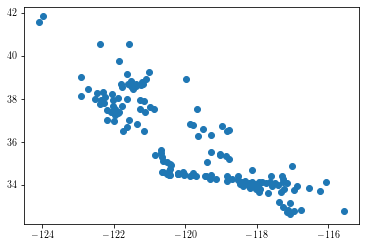

In [17]:
plt.scatter(cadf['Longitude'], cadf['Latitude'])

## Let us load Los Angeles Centroids for Interpolation

### Before that, let us visualize LA County and nearby regions!

In [18]:
import geopandas as gpd

Venture - 111, Orange - 59, Riverside - 65, San Bernardino - 71, LA - 36

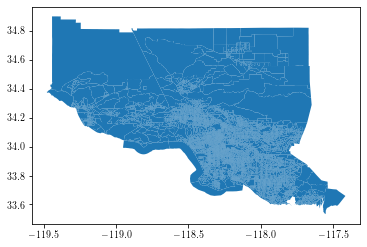

In [19]:
gdf = gpd.read_file("../block_groups/california/tl_2016_06_bg.shp")
gdf = gdf[gdf['COUNTYFP'].isin(['037', '059', '111'])]
gdf['INTPTLAT'] = np.float64(gdf['INTPTLAT'].values)
gdf['INTPTLON'] = np.float64(gdf['INTPTLON'].values)
gdf = gdf[gdf['INTPTLAT']>=33.6]
gdf = gdf[gdf['INTPTLAT']<=35.5]
gdf = gdf[gdf['INTPTLON']>=-119.4]
gdf.plot()

In [20]:
mask1 = gdf['COUNTYFP']=='037'
lagdf = gdf[gdf['COUNTYFP']=='037']

In [21]:
shapes = lagdf['geometry'].unique()
centroids = [shapes[i].centroid.wkt for i in range(len(shapes))]
centroids = [centroids[i].split(' ')[1:] for i in range(len(centroids))]
centroids = [[np.float64(centroids[i][0][1:]), np.float64(centroids[i][1][:-1])] for i in range(len(centroids))]
centroids = np.array(centroids)

In [22]:
centroids.shape

(6419, 2)

## We are only interested in LA for Kriging Interpolation of O3
## Accordingly we choose Latitude <= 34.81

In [23]:
cadf = cadf[cadf['Latitude']<=34.81]

## Let us interpolate over LA County!

In [24]:
X = cadf[['Longitude', 'Latitude']].values
y = cadf[['Sample Measurement']].values * 1000

### Kriging Interpolation

In [25]:
from polire.interpolate import Kriging
## PyKrige takes Longitude Values in the Range 0 to 360 => Add 360 to our values!
X_krig = X.copy()
X_test_krig = centroids.copy()
# X_krig[:, 0] = X_krig[:, 0] + 360
krig = Kriging(variogram_model='spherical', coordinate_type='Geographic')
krig.fit(X_krig, y)

X_test_krig[:, 0] = X_test_krig[:, 0] + 360
krig_predictions = krig.predict(X_test_krig)

### Spatial Average

In [26]:
from polire.interpolate import SpatialAverage
spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
spatial.fit(X, y)
spatial_predictions = spatial.predict(centroids)

### IDW

For IDW, the authors choose a 250 km radius. Let us likewise choose our training points and use the IDW Class repeatedly.

polire supports geographic coordinates and hence we have that distance too!

In [27]:
from polire.interpolate import Idw
from polire.utils.distance import haversine, euclidean
idw = Idw(coordinate_type='Geographic', exponent=1)
idw_predictions = np.zeros(centroids.shape[0])
for ix, data_point in enumerate(centroids):
    distances = haversine(data_point, X)
    mask = distances <= 250
    X_train = X[mask]
    y_train = y[mask]
    idw.fit(X_train, y_train)
    idw_predictions[ix] = idw.predict(data_point.reshape(1, 2))

### $k$-NN, with $k = 1$.

In [28]:
from polire.custom import CustomInterpolator
from sklearn.neighbors import KNeighborsRegressor
knn = CustomInterpolator(KNeighborsRegressor, reg_kwargs={'n_neighbors':1})
knn.fit(X, y)
knn_predictions = knn.predict(centroids)

In [29]:
krig_predictions = np.array(krig_predictions).reshape(-1,1)

In [30]:
spatial_predictions = np.array(spatial_predictions).reshape(-1,1)

In [31]:
idw_predictions = np.array(idw_predictions).reshape(-1,1)

In [32]:
gdf_krig_predictions = []
gdf_knn_predictions = []
gdf_idw_predictions = []
gdf_spav_predictions = []

ix = 0
for i in range(gdf.shape[0]):
    if mask1.values[i] == True:
        gdf_krig_predictions.append(krig_predictions[ix][0])
        ix = ix + 1
    else:
        gdf_krig_predictions.append(np.nan)

ix = 0
for i in range(gdf.shape[0]):
    if mask1.values[i] == True:
        gdf_spav_predictions.append(spatial_predictions[ix][0])
        ix = ix + 1
    else:
        gdf_spav_predictions.append(np.nan)

ix = 0
for i in range(gdf.shape[0]):
    if mask1.values[i] == True:
        gdf_idw_predictions.append(idw_predictions[ix][0])
        ix = ix + 1
    else:
        gdf_idw_predictions.append(np.nan)

ix = 0
for i in range(gdf.shape[0]):
    if mask1.values[i] == True:
        gdf_knn_predictions.append(knn_predictions[ix][0])
        ix = ix + 1
    else:
        gdf_knn_predictions.append(np.nan)


In [33]:
polygon = gdf.geometry.unary_union
gdf2 = gpd.GeoDataFrame(geometry=[polygon], crs=gdf.crs)

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)
ax.axis('Off')
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf.plot(column='Example', ax=ax, legend=True, cax=cax)

In [35]:
gdf['Kriging'] = gdf_krig_predictions
gdf['IDW'] = gdf_idw_predictions
gdf['Spatial'] = gdf_spav_predictions
gdf['KNN'] = gdf_knn_predictions

In [36]:
temp = []
for i in gdf_spav_predictions:
    try:
        j = i[0]
        temp.append(j)
    except:
        temp.append(i)

In [37]:
gdf['Spatial'] = temp

(-119.58156985000001, -117.30972115000002, 33.465384300000004, 34.9696497)

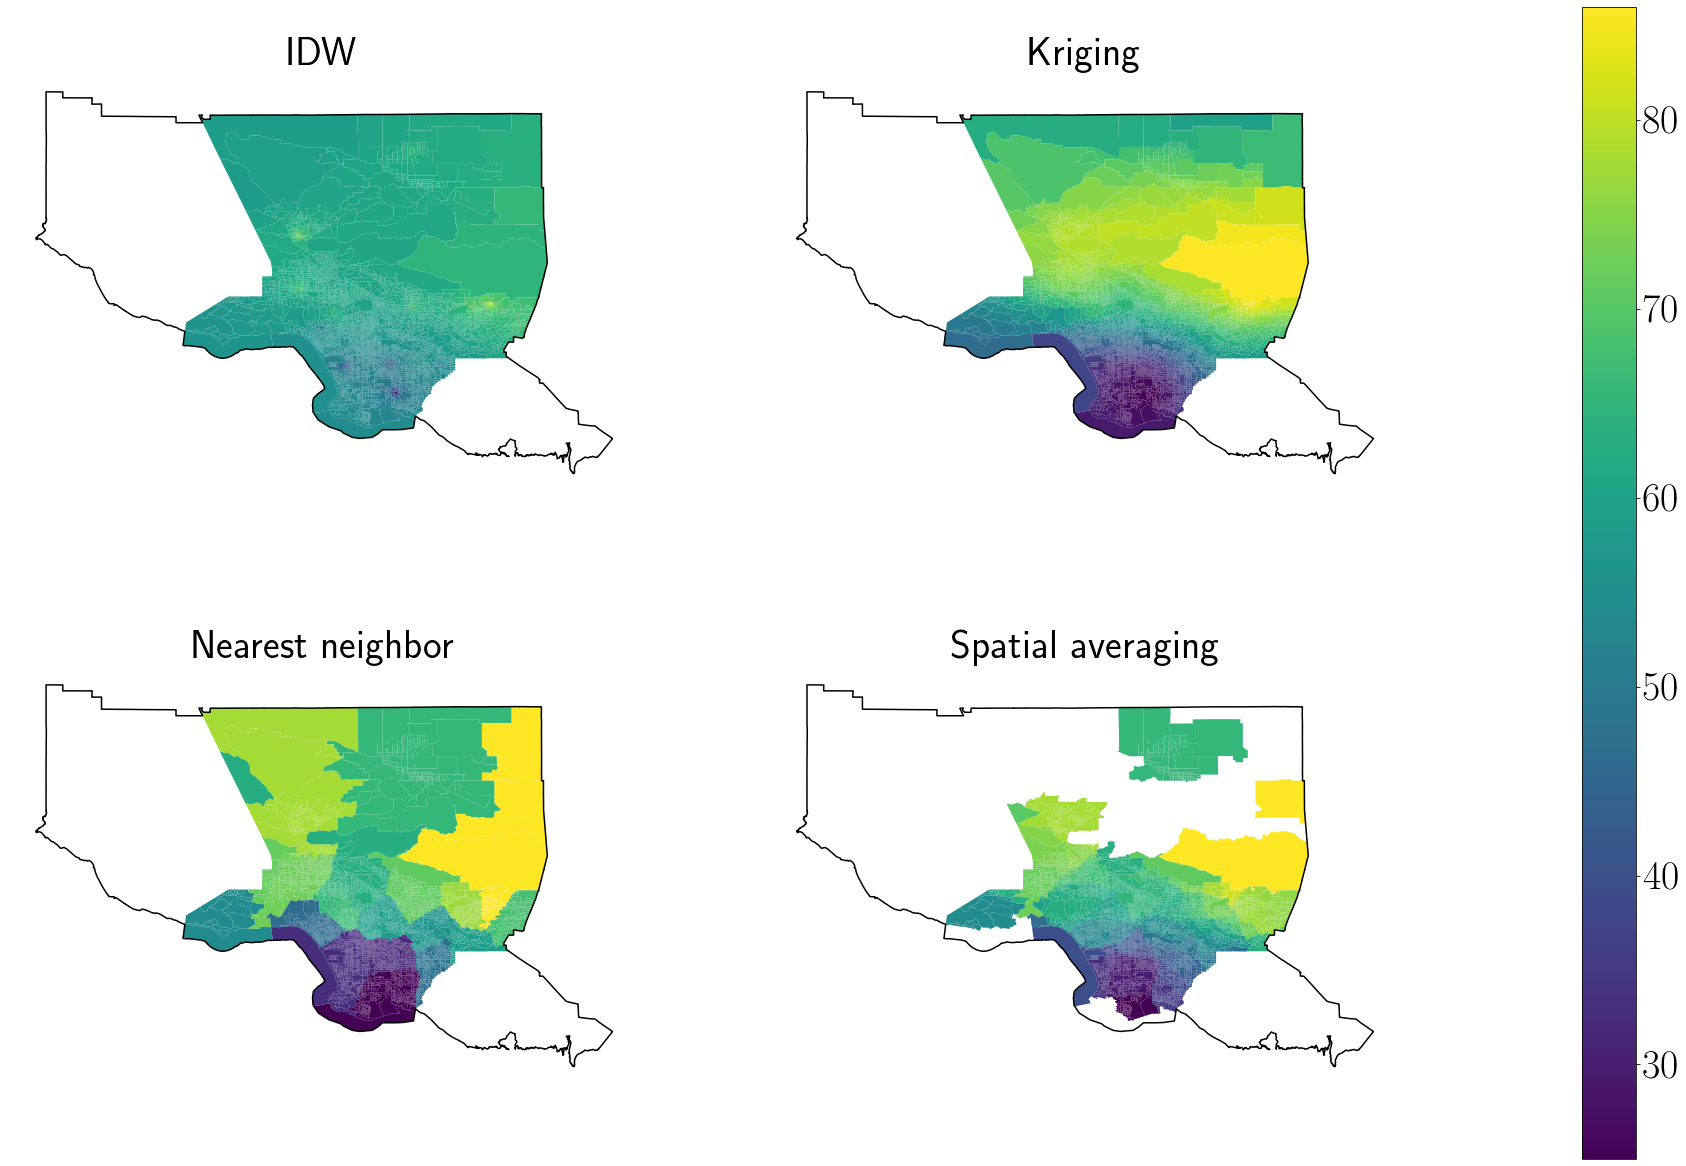

In [38]:
fig, ax = plt.subplots(2,2, figsize=(25, 20))

ax[0, 0].set_title("IDW", fontsize=40)
gdf2.geometry.boundary.plot(color=None,edgecolor='black',linewidth = 1.5, ax=ax[0][0])
gdf.plot(column='IDW', legend=False, ax = ax[0][0])
ax[0, 0].axis('Off')

ax[0, 1].set_title("Kriging", fontsize=40)
gdf2.geometry.boundary.plot(color=None,edgecolor='black',linewidth = 1.5, ax=ax[0, 1])
gdf.plot(column='Kriging', legend=False, ax = ax[0,1])
ax[0, 1].axis('Off')

ax[1, 0].set_title("Nearest neighbor", fontsize=40)
gdf2.geometry.boundary.plot(color=None,edgecolor='black',linewidth = 1.5, ax=ax[1, 0])
gdf.plot(column='KNN', legend=False, ax=ax[1, 0])
ax[1,0].axis('Off')

ax[1, 1].set_title("Spatial averaging", fontsize=40)

# divider = make_axes_locatable(ax[1][1])
# cax = divider.append_axes("right", size="5%", pad=0.1)
# cax.set_label("$O_3$ Values")


vmin = 25
vmax =86
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax,)
cbr.ax.tick_params(labelsize=40) 
# plt.tight_layout()

gdf2.geometry.boundary.plot(color=None,edgecolor='black',linewidth = 1.5, ax=ax[1, 1])
gdf.plot(column='Spatial', legend=False, ax=ax[1, 1])

ax[1,1].axis('Off')